#### __14. 합성곱 신경망을 사용하는 컴퓨터 비전__



In [1]:
import os
import sys
 
import sklearn
import tensorflow as tf

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

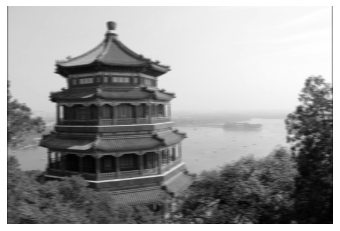

In [18]:
from sklearn.datasets import load_sample_image

# 샘플 이미지 로드
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 필터 2개 만들기
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")  # 첫 번째 이미지의 두 번째 특성 맵 그리기
plt.axis("off")
plt.show()

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [18]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation="softmax"),
])

In [19]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 28s 15ms/step - loss: 0.6820 - accuracy: 0.7649 - val_loss: 0.3747 - val_accuracy: 0.8652
Epoch 2/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.4131 - accuracy: 0.8600 - val_loss: 0.3272 - val_accuracy: 0.8800
Epoch 3/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3623 - accuracy: 0.8761 - val_loss: 0.3017 - val_accuracy: 0.8892
Epoch 4/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3264 - accuracy: 0.8903 - val_loss: 0.2893 - val_accuracy: 0.8950
Epoch 5/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3020 - accuracy: 0.8974 - val_loss: 0.2955 - val_accuracy: 0.8938
Epoch 6/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2830 - accuracy: 0.9028 - val_loss: 0.2931 - val_accuracy: 0.8986
Epoch 7/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2734 - accuracy: 0.9069 - val_loss: 0.2935 -

__14.5 ResNet-34 구현__

In [8]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                         padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit_1 (ResidualUn  (None, 56, 56, 64)       74240     
 it)                                                             
                                                      

__14.6 케라스에서 제공하는 사전훈련된 모델 사용하기__

In [17]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 2s 0us/step


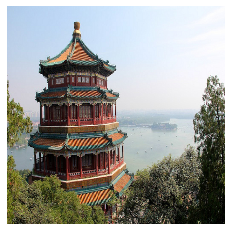

In [19]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


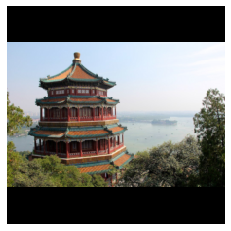

In [20]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

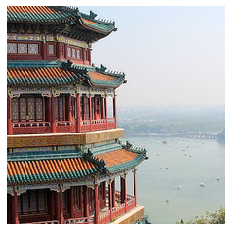

In [26]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

In [27]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [28]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 857ms/step


In [29]:
Y_proba.shape

(2, 1000)

In [37]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"이미지 #: {image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"{class_id} - {name:12s} {y_proba * 100:.2f}")
        print()

35363/35363 [==============================] - 0s 0us/step
이미지 #: 0
n03877845 - palace       92.34

n03781244 - monastery    5.34

n02825657 - bell_cote    0.94

이미지 #: 1
n04522168 - vase         38.43

n07930864 - cup          8.87

n11939491 - daisy        8.10



__14.7 사전훈련된 모델을 사용한 전이  학습__

In [41]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Kang MinJae\tensorflow_datasets\tf_flowers\3.0.1.incomplete5UT9OG\tf_flowers-train.tfrecord…

Dataset tf_flowers downloaded and prepared to C:\Users\Kang MinJae\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [42]:
info.splits

{Split('train'): <SplitInfo num_examples=3670, num_shards=2>}

In [44]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [45]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [46]:
n_classes = info.features["label"].num_classes

In [47]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [49]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

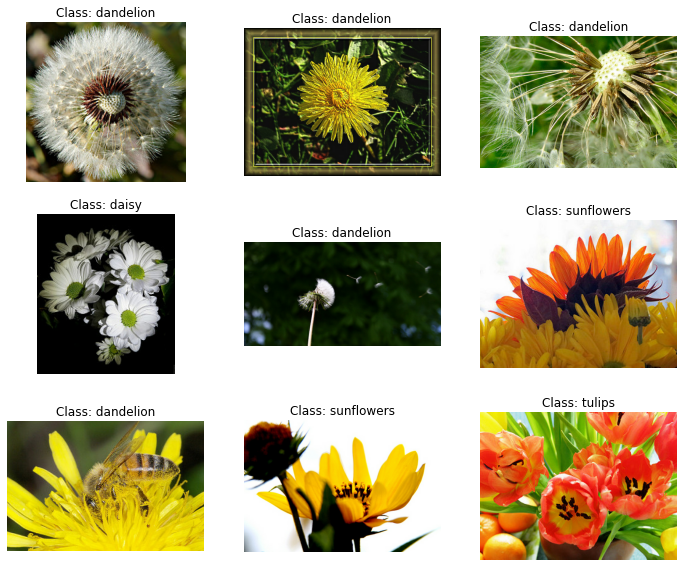

In [50]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")
plt.show()

In [51]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [62]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [63]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

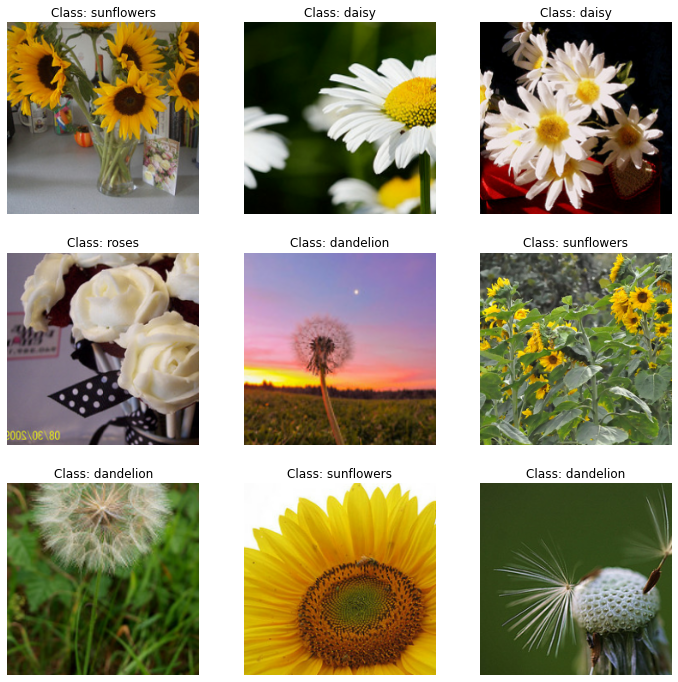

In [64]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

In [65]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [66]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_42
13 block2_pool
14 batch_normalization_42
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_43
23 block3_pool
24 batch_normalization_43
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_44
33 block4_pool
34 batch_normalization_44
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [67]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.75 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 1.4265 - accuracy: 0.7936WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 86 batches). You may need to use the repeat() function when building your dataset.


86/86 [==============================] - 9s 80ms/step - loss: 1.4265 - accuracy: 0.7936 - val_loss: 1.5456 - val_accuracy: 0.8149
Epoch 2/5
86/86 [==============================] - 5s 57ms/step - loss: 0.6448 - accuracy: 0.8993
Epoch 3/5
86/86 [==============================] - 5s 56ms/step - loss: 0.4375 - accuracy: 0.9121
Epoch 4/5
86/86 [==============================] - 5s 56ms/step - loss: 0.2414 - accuracy: 0.9397
Epoch 5/5
86/86 [==============================] - 5s 58ms/step - loss: 0.2029 - accuracy: 0.9433


In [68]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 27s 266ms/step - loss: 0.3557 - accuracy: 0.8808 - val_loss: 0.5175 - val_accuracy: 0.8511
Epoch 2/40
86/86 [==============================] - 22s 255ms/step - loss: 0.1225 - accuracy: 0.9622 - val_loss: 0.2162 - val_accuracy: 0.9210
Epoch 3/40
86/86 [==============================] - 25s 290ms/step - loss: 0.0624 - accuracy: 0.9826 - val_loss: 0.2258 - val_accuracy: 0.9375
Epoch 4/40
86/86 [==============================] - 24s 284ms/step - loss: 0.0483 - accuracy: 0.9844 - val_loss: 0.2807 - val_accuracy: 0.9062
Epoch 5/40
86/86 [==============================] - 24s 283ms/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.2495 - val_accuracy: 0.9228
Epoch 6/40
86/86 [==============================] - 24s 283ms/step - loss: 0.0245 - accuracy: 0.9909 - val_loss: 0.2836 - val_accuracy: 0.9154
Epoch 7/40
86/86 [==============================] - 24s 283ms/step - loss: 0.0281 - accuracy: 0.9920 - val_loss: 0.2697 - val_accuracy: 0.9191

__14.8 분류와 위치 추정__

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # 어떤 것을 중요하게 생각하느냐에 따라
              optimizer=optimizer, metrics=["accuracy"])